In [23]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
import datetime

In [24]:
def variance(w, cov):
    return np.dot(w.T, np.dot(cov,w))

def returns(w, exp):
    return np.dot(w.T, exp)

In [25]:
DATA_PATH = '../data'
PRICES_PATH = os.path.join(DATA_PATH, 'prices')
SIMULATION_DATA_PATH = os.path.join(DATA_PATH, 'simulation data')
prices = pd.read_csv(os.path.join(PRICES_PATH, 'Spain_prices.csv'))

In [26]:
prices['price'] = prices['Price (EUR/MWhe)']
prices['time'] = pd.to_datetime(prices['Datetime (UTC)'])
prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe),price,time
0,Spain,ESP,2015-01-01 00:00:00,2015-01-01 01:00:00,48.10,48.10,2015-01-01 00:00:00
1,Spain,ESP,2015-01-01 01:00:00,2015-01-01 02:00:00,47.33,47.33,2015-01-01 01:00:00
2,Spain,ESP,2015-01-01 02:00:00,2015-01-01 03:00:00,42.27,42.27,2015-01-01 02:00:00
3,Spain,ESP,2015-01-01 03:00:00,2015-01-01 04:00:00,38.41,38.41,2015-01-01 03:00:00
4,Spain,ESP,2015-01-01 04:00:00,2015-01-01 05:00:00,35.72,35.72,2015-01-01 04:00:00


In [27]:
df_list = []
for file_name in os.listdir(SIMULATION_DATA_PATH):
    df = pd.read_csv(os.path.join(SIMULATION_DATA_PATH, file_name),sep = ',', comment = '#')
    file_name_split = file_name.split('_')
    df['lat_lon'] = file_name_split[2]+ '_' + file_name_split[3]
    df_list.append(df)
production = pd.concat(df_list)

In [28]:
production['time'] = pd.to_datetime(production['time'])
production.head()

,time,local_time,electricity,lat_lon
0,2019-01-01 00:00:00,2019-01-01 01:00,0.251,37.3467_-5.6815
1,2019-01-01 01:00:00,2019-01-01 02:00,0.259,37.3467_-5.6815
2,2019-01-01 02:00:00,2019-01-01 03:00,0.261,37.3467_-5.6815
3,2019-01-01 03:00:00,2019-01-01 04:00,0.248,37.3467_-5.6815
4,2019-01-01 04:00:00,2019-01-01 05:00,0.243,37.3467_-5.6815


In [29]:
production['hour'] = production['time'].dt.hour
production['day'] = production['time'].dt.day
production['month'] = production['time'].dt.month
production['year'] = production['time'].dt.year

prices['hour'] = prices['time'].dt.hour
prices['day'] = prices['time'].dt.day
prices['month'] = prices['time'].dt.month
prices['year'] = prices['time'].dt.year

In [30]:
final_time_price = prices['time'].max() #- pd.Timedelta(days=1) + pd.Timedelta(hours=1)
start_time_price = final_time_price - pd.Timedelta(days=365)

In [31]:
mask_dates = (prices['time'] <= final_time_price) & (prices['time'] > start_time_price)
last_y_prices = prices[mask_dates]

In [32]:
last_y_prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe),price,time,hour,day,month,year
83469,Spain,ESP,2024-07-09 21:00:00,2024-07-09 23:00:00,116.38,116.38,2024-07-09 21:00:00,21,9,7,2024
83470,Spain,ESP,2024-07-09 22:00:00,2024-07-10 00:00:00,107.94,107.94,2024-07-09 22:00:00,22,9,7,2024
83471,Spain,ESP,2024-07-09 23:00:00,2024-07-10 01:00:00,106.81,106.81,2024-07-09 23:00:00,23,9,7,2024
83472,Spain,ESP,2024-07-10 00:00:00,2024-07-10 02:00:00,104.22,104.22,2024-07-10 00:00:00,0,10,7,2024
83473,Spain,ESP,2024-07-10 01:00:00,2024-07-10 03:00:00,102.61,102.61,2024-07-10 01:00:00,1,10,7,2024


In [33]:
production.head()

,time,local_time,electricity,lat_lon,hour,day,month,year
0,2019-01-01 00:00:00,2019-01-01 01:00,0.251,37.3467_-5.6815,0,1,1,2019
1,2019-01-01 01:00:00,2019-01-01 02:00,0.259,37.3467_-5.6815,1,1,1,2019
2,2019-01-01 02:00:00,2019-01-01 03:00,0.261,37.3467_-5.6815,2,1,1,2019
3,2019-01-01 03:00:00,2019-01-01 04:00,0.248,37.3467_-5.6815,3,1,1,2019
4,2019-01-01 04:00:00,2019-01-01 05:00,0.243,37.3467_-5.6815,4,1,1,2019


In [35]:
df_revenue = pd.merge(production, last_y_prices, on=['hour','day','month'], how='inner')
df_revenue = df_revenue[['lat_lon','price','electricity','hour','day','month']]

In [36]:
# compute asset revenue
df_revenue['revenue'] = df_revenue['price'] * df_revenue['electricity']
df_revenue['year'] = 2019
df_revenue['time_stamp'] = df_revenue[['year', 'month', 'day', 'hour']].apply(lambda s : datetime.datetime(*s),axis = 1)

In [37]:
monthly_rev = pd.pivot_table(df_revenue, values='revenue', index='time_stamp', columns='lat_lon', aggfunc='sum')
monthly_rev

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
time_stamp,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,33.02909,19.87009,0.39477,12.76423,13.15900,69.61111,24.08097,18.81737,36.58202,2.23703,2.63180,29.87093,26.84436,76.58538,10.92197,20.39645,21.71235,8.15858,1.05272,51.32010
2019-01-01 01:00:00,34.05591,19.72350,0.39447,12.49155,13.54347,75.08079,23.66820,16.30476,24.06267,3.02427,2.76129,27.61290,31.42611,78.23655,10.38771,16.30476,21.95883,10.51920,0.65745,49.04577
2019-01-01 02:00:00,34.30062,17.87312,0.52568,11.43354,12.61632,77.53780,21.68430,15.50756,17.21602,4.33686,3.02266,28.51814,35.74624,81.21756,10.25076,16.03324,21.02720,13.53626,1.05136,46.39126
2019-01-01 03:00:00,29.88152,12.16949,0.96392,7.95234,8.19332,74.46282,14.69978,15.18174,12.41047,5.30156,3.01225,26.98976,33.97818,77.11360,9.88018,15.06125,16.74811,14.09733,1.56637,38.91827
2019-01-01 04:00:00,27.28890,7.52410,2.24600,4.94120,4.37970,73.44420,8.75940,16.39580,12.35300,6.06420,3.03210,24.36910,31.21940,73.89340,10.10700,14.03750,13.13910,12.57760,2.24600,31.55630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,22.63450,7.80500,3.12200,0.78050,0.78050,5.46350,9.83430,2.80980,6.40010,0.46830,0.62440,11.08310,11.23920,2.96590,0.93660,8.11720,39.64940,2.34150,0.46830,3.90250
2019-12-31 20:00:00,24.28685,9.95610,2.56445,0.90510,1.05595,5.27975,9.05100,3.31870,8.14590,1.05595,1.20680,10.71035,10.71035,9.05100,1.05595,6.78825,37.41080,1.05595,0.60340,5.58145
2019-12-31 21:00:00,24.11480,12.70720,2.88800,2.02160,1.44400,5.92040,8.37520,5.48720,8.95280,1.73280,2.02160,10.39680,9.09720,13.86240,1.58840,5.19840,33.64520,0.57760,2.31040,8.51960


In [38]:
cov = monthly_rev.cov()
exp = monthly_rev.sum()

In [39]:
# Hourly correlation is still very big although some points close to 0.5 
monthly_rev.corr()

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
lat_lon,,,,,,,,,,,,,,,,,,,,
37.3467_-5.6815,1.000000,0.911575,0.677568,0.821089,0.872751,0.597181,0.858806,0.702995,0.549168,0.762972,0.704127,0.544645,0.677923,0.630472,0.689946,0.551101,0.597882,0.607766,0.611486,0.587454
37.5021_-4.4298,0.911575,1.000000,0.722266,0.868972,0.872836,0.590960,0.818252,0.721791,0.541304,0.769579,0.692802,0.552731,0.668060,0.612945,0.696257,0.568978,0.568050,0.586779,0.600938,0.565304
37.6571_-2.4870,0.677568,0.722266,1.000000,0.794141,0.742312,0.867996,0.687648,0.790000,0.717770,0.761707,0.650148,0.701093,0.666725,0.715434,0.711083,0.672782,0.552724,0.616414,0.673416,0.635042
38.3250_-3.2432,0.821089,0.868972,0.794141,1.000000,0.879412,0.639370,0.805384,0.769734,0.561245,0.817785,0.708104,0.553838,0.703365,0.639416,0.754345,0.563856,0.589063,0.603653,0.606588,0.606398
38.4885_-5.0687,0.872751,0.872836,0.742312,0.879412,1.000000,0.632993,0.910957,0.785274,0.604089,0.856686,0.785806,0.581414,0.763866,0.679083,0.777851,0.586352,0.618096,0.632199,0.649852,0.627257
38.5089_-1.1831,0.597181,0.590960,0.867996,0.639370,0.632993,1.000000,0.609225,0.759989,0.790488,0.677653,0.604717,0.741168,0.613072,0.731718,0.637688,0.692436,0.552369,0.591121,0.649159,0.621148
38.7432_-6.7377,0.858806,0.818252,0.687648,0.805384,0.910957,0.609225,1.000000,0.743556,0.567522,0.838801,0.827790,0.561168,0.797501,0.684324,0.782880,0.565091,0.661971,0.647093,0.675734,0.649000
40.2523_-1.9654,0.702995,0.721791,0.790000,0.769734,0.785274,0.759989,0.743556,1.000000,0.793686,0.873493,0.784616,0.755265,0.773994,0.836356,0.845679,0.766696,0.650067,0.731566,0.702839,0.675584
40.3220_-0.1269,0.549168,0.541304,0.717770,0.561245,0.604089,0.790488,0.567522,0.793686,1.000000,0.689234,0.631533,0.787013,0.565747,0.768045,0.601442,0.754284,0.494974,0.597510,0.589121,0.535861


In [17]:
monthly_rev.corr()

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
lat_lon,,,,,,,,,,,,,,,,,,,,
37.3467_-5.6815,1.000000,0.911575,0.677568,0.821089,0.872751,0.597181,0.858806,0.702995,0.549168,0.762972,0.704127,0.544645,0.677923,0.630472,0.689946,0.551101,0.597882,0.607766,0.611486,0.587454
37.5021_-4.4298,0.911575,1.000000,0.722266,0.868972,0.872836,0.590960,0.818252,0.721791,0.541304,0.769579,0.692802,0.552731,0.668060,0.612945,0.696257,0.568978,0.568050,0.586779,0.600938,0.565304
37.6571_-2.4870,0.677568,0.722266,1.000000,0.794141,0.742312,0.867996,0.687648,0.790000,0.717770,0.761707,0.650148,0.701093,0.666725,0.715434,0.711083,0.672782,0.552724,0.616414,0.673416,0.635042
38.3250_-3.2432,0.821089,0.868972,0.794141,1.000000,0.879412,0.639370,0.805384,0.769734,0.561245,0.817785,0.708104,0.553838,0.703365,0.639416,0.754345,0.563856,0.589063,0.603653,0.606588,0.606398
38.4885_-5.0687,0.872751,0.872836,0.742312,0.879412,1.000000,0.632993,0.910957,0.785274,0.604089,0.856686,0.785806,0.581414,0.763866,0.679083,0.777851,0.586352,0.618096,0.632199,0.649852,0.627257
38.5089_-1.1831,0.597181,0.590960,0.867996,0.639370,0.632993,1.000000,0.609225,0.759989,0.790488,0.677653,0.604717,0.741168,0.613072,0.731718,0.637688,0.692436,0.552369,0.591121,0.649159,0.621148
38.7432_-6.7377,0.858806,0.818252,0.687648,0.805384,0.910957,0.609225,1.000000,0.743556,0.567522,0.838801,0.827790,0.561168,0.797501,0.684324,0.782880,0.565091,0.661971,0.647093,0.675734,0.649000
40.2523_-1.9654,0.702995,0.721791,0.790000,0.769734,0.785274,0.759989,0.743556,1.000000,0.793686,0.873493,0.784616,0.755265,0.773994,0.836356,0.845679,0.766696,0.650067,0.731566,0.702839,0.675584
40.3220_-0.1269,0.549168,0.541304,0.717770,0.561245,0.604089,0.790488,0.567522,0.793686,1.000000,0.689234,0.631533,0.787013,0.565747,0.768045,0.601442,0.754284,0.494974,0.597510,0.589121,0.535861


In [40]:
# Random weights
n_samples = 1000
n_locations = monthly_rev.shape[1]

w_np = np.random.uniform(size=(n_samples, n_locations))
w_np /= w_np.sum(axis=1, keepdims=True)
df_w = pd.DataFrame(w_np, columns=monthly_rev.columns)
df_w

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
0,0.065581,0.027343,0.070363,0.018535,0.084732,0.087581,0.010182,0.048692,0.075534,0.042782,0.020999,0.025078,0.025095,0.070411,0.039582,0.058904,0.023962,0.059364,0.073840,0.071441
1,0.056077,0.029760,0.035315,0.068058,0.065350,0.028753,0.057616,0.062232,0.055414,0.014894,0.037264,0.074960,0.082079,0.059058,0.007571,0.053706,0.063943,0.072578,0.041687,0.033686
2,0.034403,0.021523,0.047464,0.007814,0.056725,0.026110,0.099402,0.068911,0.093962,0.103508,0.065634,0.090187,0.069201,0.004315,0.009434,0.022581,0.033839,0.030791,0.016099,0.098097
3,0.068363,0.061442,0.070461,0.049843,0.032314,0.083208,0.033718,0.033573,0.027156,0.020699,0.050054,0.040634,0.029687,0.049582,0.052611,0.049526,0.076670,0.097431,0.023017,0.050011
4,0.004598,0.062956,0.057904,0.062797,0.043650,0.064263,0.068829,0.066785,0.070832,0.004885,0.068417,0.069197,0.060301,0.068736,0.044262,0.027167,0.021245,0.048794,0.049717,0.034665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.072703,0.084109,0.032532,0.068649,0.022964,0.063388,0.077570,0.021107,0.066630,0.009740,0.078344,0.032579,0.018189,0.050118,0.058192,0.051115,0.076185,0.071030,0.013429,0.031428
996,0.080772,0.084541,0.014386,0.074796,0.035663,0.039509,0.074736,0.011047,0.026405,0.041076,0.006076,0.046838,0.002816,0.049003,0.055250,0.086917,0.079285,0.067868,0.034285,0.088732
997,0.049963,0.054124,0.059594,0.064715,0.041766,0.032181,0.048836,0.070235,0.060979,0.027619,0.076034,0.077219,0.028819,0.074578,0.031469,0.037569,0.026898,0.020146,0.045463,0.071794
998,0.029717,0.062173,0.029231,0.015716,0.038768,0.033790,0.001914,0.038318,0.035090,0.079814,0.016251,0.094490,0.096295,0.062997,0.055139,0.080607,0.042695,0.014966,0.107949,0.064081


In [19]:
df_plot = pd.DataFrame(data = [], index=df_w.index)
df_plot['cov'] =  df_w.apply(variance, axis=1, cov=cov)
df_plot['exp'] = df_w.apply(returns, axis=1, exp=exp)

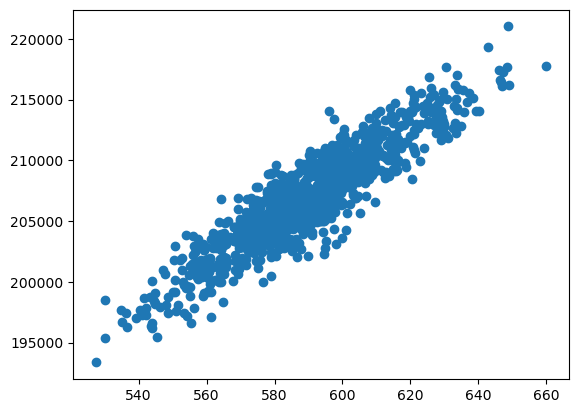

In [20]:
plt.scatter(x=df_plot['cov'], y=df_plot['exp'])
plt.show()

In [21]:
ef = EfficientFrontier(exp, cov, weight_bounds=(0,1))
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)


OrderedDict([('37.3467_-5.6815', 0.0), ('37.5021_-4.4298', 0.44462), ('37.6571_-2.4870', 0.0), ('38.3250_-3.2432', 0.0), ('38.4885_-5.0687', 0.0), ('38.5089_-1.1831', 0.0), ('38.7432_-6.7377', 0.0), ('40.2523_-1.9654', 0.0), ('40.3220_-0.1269', 0.0), ('40.3617_-4.5602', 0.0), ('40.5403_-6.2422', 0.0), ('41.3479_1.0205', 0.0), ('41.5629_-5.7467', 0.0), ('41.5727_-1.7437', 0.0), ('41.5824_-3.7648', 0.0), ('41.6591_0.8423', 0.24073), ('42.4587_-8.3965', 0.25994), ('42.9692_-1.9821', 0.05471), ('43.0932_-4.2335', 0.0), ('43.1742_-6.5667', 0.0)])
Expected annual return: 16450057.3%
Annual volatility: 2013.0%
Sharpe Ratio: 8171.81


(164500.57272483036, 20.130242848832836, 8171.812628398977)

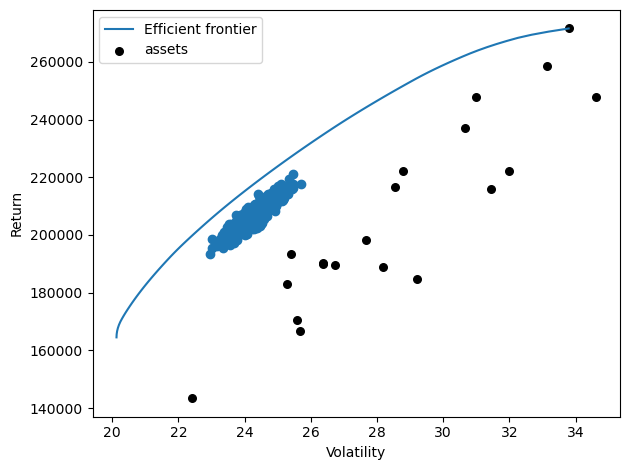

In [ ]:
# Now we get more resonable picture TODO: see which linear convinations we get the blue curve.
ef = EfficientFrontier(exp, cov,  weight_bounds=(0,1))
fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.scatter(x=np.sqrt(df_plot['cov']), y=df_plot['exp'])
plt.show()

In [ ]:
# LOOK CORRELATIONS AND SEE IF COMBINATION CAN LOWER VOLATITLITY


<Axes: xlabel='Volatility', ylabel='Return'>

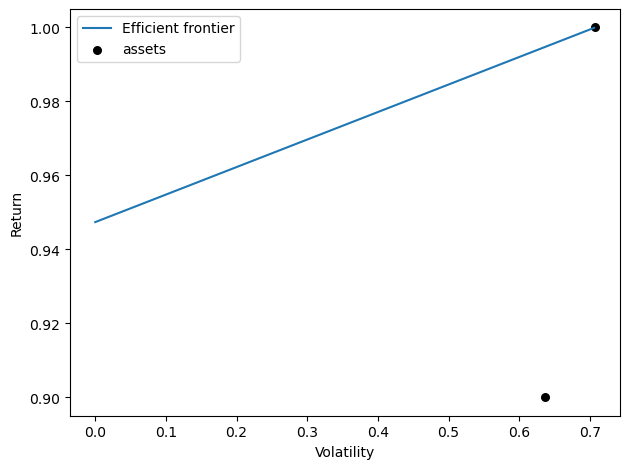

In [24]:
aux = pd.DataFrame({'A':[1,0],'B':[0,0.90]})
cov = aux.cov()
exp = aux.sum()

ef = EfficientFrontier(exp,cov,  weight_bounds=(0,1))
fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)


In [ ]:
# TODO: utilitzar els 10 anys de preus?